## Практическое задание

Вариант 1. (простой)

- обучить сверточную нейронную сеть на датасете fashion-mnist
- оценить рост точности при увеличении ширины сети (больше ядер)
- оценить рост точности при увеличении глубины сети (больше слоев)
    </li>

Вариант 2. (сложный)
- реализовать нейронную сеть в стиле AlexNet (с падением размера ядра свертки и последовательностью блоков свертка-пулинг  (conv-pool)-(conv-pool)-...) на сifar10.
- оценить рост точности при увеличении ширины сети (больше ядер)
- оценить рост точности при увеличении глубины сети (больше слоев)
    </li>
</ol>

### Подключение библиотек и скриптов

In [1]:
from IPython.core.display import display, HTML, Image
display(HTML("<style>.container { width:72.5% !important; }</style>"))

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, AveragePooling2D, Activation, MaxPooling2D, BatchNormalization, Concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras import regularizers, optimizers

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\Admin\anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Admin\anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\Admin\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [3]:
plt.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)

In [ ]:
def plot_model(history): 
    fig, axs = plt.subplots(1,2,figsize=(16,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy'], 'c') 
    axs[0].plot(history.history['val_accuracy'],'m') 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss'], 'c') 
    axs[1].plot(history.history['val_loss'], 'm') 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper right')
    plt.show()

### AlexNet — свёрточная нейронная сеть для классификации изображений

![image](img/AlexNet-1-1.png)
AlexNet — сверточная нейронная сеть, которая оказала большое влияние на развитие машинного обучения, в особенности — на алгоритмы компьютерного зрения. 

**Особенности AlexNet**
1. Как функция активации используется Relu вместо арктангенса для добавления в модель нелинейности. За счет этого при одинаковой точности метода скорость становится в 6 раз быстрее.
2. Использование дропаута вместо регуляризации решает проблему переобучения. Однако время обучения удваивается с показателем дропаута 0,5.
3. Производится перекрытие объединений для уменьшения размера сети. За счет этого уровень ошибок первого и пятого уровней снижаются до 0,4% и 0,3%, соответственно.

**Архитектура**
![image](img/Capture-12-1.jpg)
AlexNet содержит восемь слоев с весовыми коэффициентами. Первые пять из них сверточные, а остальные три — полносвязные. Выходные данные пропускаются через функцию потерь softmax, которая формирует распределение 1000 меток классов. Сеть максимизирует многолинейную логистическую регрессию, что эквивалентно максимизации среднего по всем обучающим случаям логарифма вероятности правильной маркировки по распределению ожидания. Ядра второго, четвертого и пятого сверточных слоев связаны только с теми картами ядра в предыдущем слое, которые находятся на одном и том же графическом процессоре. Ядра третьего сверточного слоя связаны со всеми картами ядер второго слоя. Нейроны в полносвязных слоях связаны со всеми нейронами предыдущего слоя.

Таким образом, AlexNet содержит 5 сверточных слоев и 3 полносвязных слоя. Relu применяется после каждого сверточного и полносвязного слоя. Дропаут применяется перед первым и вторым полносвязными слоями. Сеть содержит 62,3 миллиона параметров и затрачивает 1,1 миллиарда вычислений при прямом проходе.  Сверточные слои, на которые приходится 6% всех параметров, производят 95% вычислений.

### Загрузка данных

In [4]:
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

### Изучение датасета

In [5]:
x_train.shape

(50000, 32, 32, 3)

In [6]:
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

In [7]:
y_train.shape

(50000, 1)

In [8]:
x_test.shape

(10000, 32, 32, 3)

In [9]:
y_test

array([[3],
       [8],
       [8],
       ...,
       [5],
       [1],
       [7]], dtype=uint8)

In [10]:
y_test.shape

(10000, 1)

### Построение модели

In [11]:
# Normalizing
x_train = x_train / 255
x_test = x_test / 255

# One hot encoding
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

![image](img/models.png)

### Model - 1

In [12]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(4, 4), input_shape=(32, 32, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Conv2D(filters=32, kernel_size=(4, 4), input_shape=(32, 32, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(10, activation='softmax')
])

In [13]:
model.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

In [14]:
history = model.fit(x_train, y_train_cat, epochs=20, validation_data=(x_test, y_test_cat))

Epoch 1/20
1563/1563 [==============================] - 38s 25ms/step - loss: 1.5289 - accuracy: 0.4460 - val_loss: 1.3964 - val_accuracy: 0.4987
Epoch 2/20
1563/1563 [==============================] - 41s 26ms/step - loss: 1.2186 - accuracy: 0.5664 - val_loss: 1.2070 - val_accuracy: 0.5644
Epoch 3/20
1563/1563 [==============================] - 40s 26ms/step - loss: 1.0875 - accuracy: 0.6155 - val_loss: 1.1342 - val_accuracy: 0.5986
Epoch 4/20
1563/1563 [==============================] - 39s 25ms/step - loss: 0.9912 - accuracy: 0.6526 - val_loss: 1.0231 - val_accuracy: 0.6432
Epoch 5/20
1563/1563 [==============================] - 39s 25ms/step - loss: 0.9171 - accuracy: 0.6786 - val_loss: 0.9825 - val_accuracy: 0.6567
Epoch 6/20
1563/1563 [==============================] - 40s 25ms/step - loss: 0.8469 - accuracy: 0.7033 - val_loss: 0.9784 - val_accuracy: 0.6658
Epoch 7/20
1563/1563 [==============================] - 40s 25ms/step - loss: 0.7914 - accuracy: 0.7229 - val_loss: 1.0486 -

In [ ]:
score = model.evaluate(x_train, y_train_cat, verbose=0)
score_test = model.evaluate(x_test, y_test_cat, verbose=0)

In [ ]:
print('Train loss:', score[0])
print('Train accuracy:', score[1])
print('Test loss:', score_test[0])
print('Test accuracy:', score_test[1])

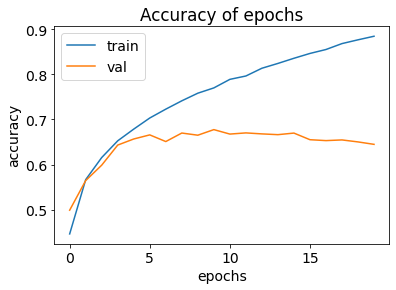

In [17]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Accuracy of epochs')
plt.show()

### Model - 2

In [18]:
# Add Drop out
model_2 = Sequential([
    Conv2D(filters=32, kernel_size=(4, 4), input_shape=(32, 32, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25), # Drop 25% of the units from the layer
    Conv2D(filters=32, kernel_size=(4, 4), input_shape=(32, 32, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(10, activation='softmax')
])

In [19]:
model_2.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

In [20]:
history_2 = model_2.fit(x_train, y_train_cat, epochs=20, validation_data=(x_test, y_test_cat))

Epoch 1/20
1563/1563 [==============================] - 47s 30ms/step - loss: 1.5510 - accuracy: 0.4345 - val_loss: 1.3424 - val_accuracy: 0.5227
Epoch 2/20
1563/1563 [==============================] - 43s 27ms/step - loss: 1.2712 - accuracy: 0.5499 - val_loss: 1.1883 - val_accuracy: 0.5878
Epoch 3/20
1563/1563 [==============================] - 43s 27ms/step - loss: 1.1413 - accuracy: 0.5959 - val_loss: 1.0457 - val_accuracy: 0.6313
Epoch 4/20
1563/1563 [==============================] - 42s 27ms/step - loss: 1.0396 - accuracy: 0.6329 - val_loss: 0.9621 - val_accuracy: 0.6721
Epoch 5/20
1563/1563 [==============================] - 43s 28ms/step - loss: 0.9695 - accuracy: 0.6590 - val_loss: 0.9534 - val_accuracy: 0.6684
Epoch 6/20
1563/1563 [==============================] - 42s 27ms/step - loss: 0.9164 - accuracy: 0.6770 - val_loss: 0.9442 - val_accuracy: 0.6754
Epoch 7/20
1563/1563 [==============================] - 42s 27ms/step - loss: 0.8676 - accuracy: 0.6948 - val_loss: 0.8869 -

In [21]:
score_2 = model_2.evaluate(x_train, y_train_cat, verbose=0)

In [22]:
print('Test loss:', score_2[0])
print('Test accuracy:', score_2[1])

Test loss: 0.32221928238868713
Test accuracy: 0.9034000039100647


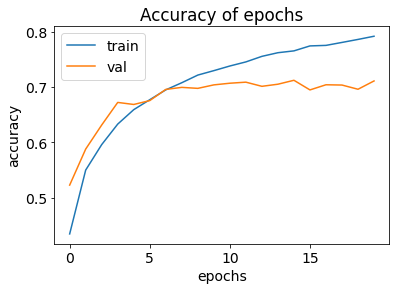

In [23]:
plt.plot(history_2.history['accuracy'], label='train')
plt.plot(history_2.history['val_accuracy'], label='val')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Accuracy of epochs')
plt.show()

### Model - 3

In [24]:
# Add More layers with more filters
model_3 = Sequential([
    Conv2D(filters=64, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu'),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.4), # Drop 40% of the units from the layer
    
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.4),
    
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(10, activation='softmax')
])

In [25]:
model_3.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

In [26]:
history_3 = model_3.fit(x_train, y_train_cat, epochs=50, validation_data=(x_test, y_test_cat))

Epoch 1/50
1563/1563 [==============================] - 364s 233ms/step - loss: 1.5748 - accuracy: 0.4237 - val_loss: 1.2561 - val_accuracy: 0.5510
Epoch 2/50
1563/1563 [==============================] - 373s 239ms/step - loss: 1.1975 - accuracy: 0.5741 - val_loss: 1.0644 - val_accuracy: 0.6156
Epoch 3/50
1563/1563 [==============================] - 355s 227ms/step - loss: 1.0289 - accuracy: 0.6350 - val_loss: 0.8847 - val_accuracy: 0.6947
Epoch 4/50
1563/1563 [==============================] - 340s 217ms/step - loss: 0.9214 - accuracy: 0.6746 - val_loss: 0.8704 - val_accuracy: 0.6961
Epoch 5/50
1563/1563 [==============================] - 339s 217ms/step - loss: 0.8371 - accuracy: 0.7033 - val_loss: 0.8126 - val_accuracy: 0.7227
Epoch 6/50
1563/1563 [==============================] - 340s 217ms/step - loss: 0.7844 - accuracy: 0.7236 - val_loss: 0.7809 - val_accuracy: 0.7259
Epoch 7/50
1563/1563 [==============================] - 340s 218ms/step - loss: 0.7352 - accuracy: 0.7404 - val_

KeyboardInterrupt: 

In [ ]:
score_3 = model_3.evaluate(x_train, y_train_cat, verbose=0)

In [ ]:
print('Test loss:', score_3[0])
print('Test accuracy:', score_3[1])

In [ ]:
plt.plot(history_3.history['accuracy'], label='train')
plt.plot(history_3.history['val_accuracy'], label='val')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Accuracy of epochs')
plt.show()

### Model - 4

In [ ]:
# Increased layers and Filters along with Increased dropout
model_4 = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), input_shape=(32, 32, 3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    Conv2D(filters=32, kernel_size=(3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.2), # Drop 20% of the units from the layer
    
    Conv2D(filters=64, kernel_size=(3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    Conv2D(filters=64, kernel_size=(3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.3), # Drop 30% of the units from the layer
    
    Conv2D(filters=128, kernel_size=(3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    Conv2D(filters=128, kernel_size=(3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.4), # Drop 40% of the units from the layer
    
    Flatten(),
    Dense(128, activation='relu', kernel_initializer='he_uniform'),
    Dropout(0.5), # Drop 50% of the units from the layer
    Dense(10, activation='softmax')
])

In [ ]:
model_4.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

In [ ]:
history_4 = model_4.fit(x_train, y_train_cat, epochs=50, validation_data=(x_test, y_test_cat))

In [ ]:
score_4 = model_4.evaluate(x_train, y_train_cat, verbose=0)

In [ ]:
print('Test loss:', score_4[0])
print('Test accuracy:', score_4[1])

In [ ]:
plt.plot(history_4.history['accuracy'], label='train')
plt.plot(history_4.history['val_accuracy'], label='val')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Accuracy of epochs')
plt.show()

### Model - 5

In [ ]:
# Adding Batch Normalization
model_5 = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), input_shape=(32, 32, 3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=(3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.2), # Drop 20% of the units from the layer
    
    Conv2D(filters=64, kernel_size=(3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(filters=64, kernel_size=(3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.3), # Drop 30% of the units from the layer
    
    Conv2D(filters=128, kernel_size=(3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(filters=128, kernel_size=(3, 3), kernel_initializer='he_uniform', padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.4), # Drop 40% of the units from the layer
    
    Flatten(),
    Dense(128, activation='relu', kernel_initializer='he_uniform'),
    BatchNormalization(),
    Dropout(0.5), # Drop 50% of the units from the layer
    Dense(10, activation='softmax')
])

In [ ]:
model_5.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

In [ ]:
history_5 = model_5.fit(x_train, y_train_cat, epochs=50, validation_data=(x_test, y_test_cat))

In [ ]:
score_5 = model_5.evaluate(x_train, y_train_cat, verbose=0)

In [ ]:
print('Test loss:', score_5[0])
print('Test accuracy:', score_5[1])

In [ ]:
plt.plot(history_5.history['accuracy'], label='train')
plt.plot(history_5.history['val_accuracy'], label='val')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Accuracy of epochs')
plt.show()

In [ ]:
pd.DataFrame(history_5.history).plot()

In [ ]:
plot_model(history_5.history)

### Model - 6

In [ ]:
# run model
history_6 = model_5.fit_generator(datagen.flow(x_train, y_train_cat, batch_size = 64),
                                 validation_data = (x_test, y_test_cat),
                                 steps_per_epoch = x_train.shape[0] // 64, 
                                 epochs = 50, verbose = 1,
                                 callbacks = callback_list)

In [ ]:
plot_model(history_6.history)

### Results

In [ ]:
results = pd.DataFrame({'model_1': score, 'model_2': score_2, 'model_3': score_3, 'model_4': score_4,
                        'model_5': score_5}).T
results.columns=['loss', 'accuracy']
results

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(history.history['accuracy'], label='model-1')
plt.plot(history_2.history['accuracy'], label='model-2')
plt.plot(history_3.history['accuracy'], label='model-3')
plt.plot(history_4.history['accuracy'], label='model-4')
plt.plot(history_5.history['accuracy'], label='model-5')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Accuracy of epochs')
plt.show()

In [ ]:
model_5.summary()

При построении нейронной сети для текущего набора данных не подходит метод активации нейронов 'softmax', а также функция потерь(loss) 'categorical_crossentropy' и 'KLDivergence'. Лучшие результаты показала модель с активатором нейронов 'sigmoid', типом оптимизатора 'Adam' и функцией потерь 'binary_crossentropy', также удалось удачно подобрать число слоев и число нейронов. Другие метрики к итоговым моделям не добавлялись, остались только в качестве экспериментов.

https://www.kaggle.com/kedarsai/cifar-10-88-accuracy-using-keras
https://www.kaggle.com/kalashnimov/keras-callbacks-with-91-acc
https://www.kaggle.com/roblexnana/cifar10-with-cnn-for-beginer